### Aim to experiment the model with test signal
#### follow the dashed black line
<img src="../model_structure.jpg" alt="model_structure" width="600" />

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.autograd import Variable
from torch.nn.parameter import Parameter

# import math
# import argparse
from torch.utils.data import Dataset,DataLoader,random_split,TensorDataset
import numpy as np
import matplotlib.pyplot as plt


#### The training data can be generated from [training_dcae.ipynb](./training_dcae.ipynb) or directly from here.

In [21]:
#########################
#DCAE loading
##########################
from ..models.DCAE import Autoencoder
from ..models.gaps_generation import ge_unsche

# Create an instance of the autoencoder
autoencoder = torch.load('./models_dcae.pth')

1.4181260591074218

In [14]:
######################
#BI_GRU loading
######################
from ..models.bi_GRU import BidirectionalGRUModel

input_size = 1
hidden_size = 12
output_size = 1

# Create an instance of the bi-GRU
model = torch.load('./models_ae_gru.pth')

# Print the autoencoder architecture
print(model)

BidirectionalGRUModel(
  (gru): GRU(1, 12, num_layers=2, batch_first=True, bidirectional=True)
  (fc2): Tanh()
  (fc1): Linear(in_features=24, out_features=1, bias=True)
)


#### We consider different scenarios where the test signal is corrupted with gaps.

In [18]:
###############
## test signal
###############
tmax =  3*24*60*60                 # Final time

fs = 2*1e-3                     # Sampling rate
delta_t = 5
t = np.arange(0,tmax,delta_t)     # Form time vector from t0 = 0 to t_{n-1} = tmax. Length N [include t = zero]

a_true = 5e-21
f_true = 1e-3
fdot_true = 1e-8
testsig=a_true *(np.sin((2*np.pi)*(f_true*t + 0.5*fdot_true * t**2)))


In [33]:
#####################
## signal corruption
#####################
cortestmask=ge_unsche(t)
plt.plot(cortestmask)
maskinautoencoder=cortestmask != 0
maskinautoencoder = maskinautoencoder.astype(int)

cortestsig=testsig*maskinautoencoder
cortestsig.shape

In [34]:
#####################
# DCAE
#####################
testinput=torch.tensor(testsig.reshape((1,1,-1)))
snodata,normaldata,mean,std= autoencoder.signal_preprocess(testinput,maskinautoencoder)
output_normalized_sig=autoencoder(snodata)
outputae=output_normalized_sig.detach().numpy()

#####################
# BI-GRU
#####################
outputaenew=outputae.reshape(-1,48,1) ## DATA segmentation
outputrnn=model(torch.tensor(outputaenew))
outputrnn=outputrnn.reshape(-1,1)
forcast=outputrnn.detach().numpy()
# orgin=outputarrnew
forcast.shape


In [76]:
#####################
# Back transformation
#####################
forcastfinalae=autoencoder.signal_backprocess(output_normalized_sig,mean,std)
forcastfinalae=forcastfinalae.reshape(-1,1)
forcastae=forcastfinalae.detach().numpy()

forcastfinal=autoencoder.signal_backprocess(outputrnn*1.5,mean,std)
forcastfinal=forcastfinal.detach().numpy()
forcastoutput=testsig*maskinautoencoder+forcastfinal[:,0]*(1-maskinautoencoder)


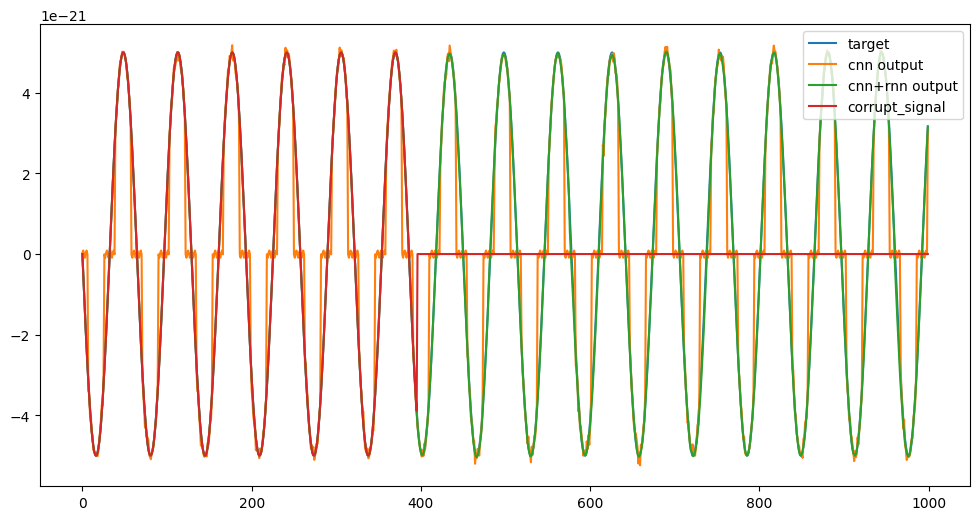

In [81]:
##########################
# final output comparsion
##########################
plt.figure(figsize=(12, 6))
plt.plot(testsig[42000:43000],label="target")
plt.plot(forcastae[42000:43000],label="cnn output")
plt.plot(forcastoutput[42000:43000],label="cnn+rnn output")
plt.plot(cortestsig[42000:43000],label="corrupt_signal")
plt.legend()